# Data Extraction and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [41]:
df = pd.read_excel("Online Retail.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [50]:
cleaned_df = df.copy()

In [51]:
cleaned_df = cleaned_df[cleaned_df['Country'] == 'United Kingdom']
cleaned_df = cleaned_df[cleaned_df['Quantity'] > 0]
cleaned_df = cleaned_df[cleaned_df['UnitPrice'] > 0]
cleaned_df = cleaned_df.dropna(subset=['InvoiceNo'])
cleaned_df = cleaned_df[~cleaned_df['InvoiceNo'].astype(str).str.startswith('C')]
cleaned_df = cleaned_df.drop(columns=["InvoiceNo", "Description", "CustomerID", "Country"])

# Feature Engineering


In [57]:
def get_season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Fall'
    
cleaned_df['Season'] = cleaned_df['InvoiceDate'].dt.month.apply(get_season)
cleaned_df['DayOfWeek'] = cleaned_df['InvoiceDate'].dt.day_name()

In [118]:
cleaned_df

,StockCode,Quantity,InvoiceDate,UnitPrice,Season,DayOfWeek
0,85123A,6,2010-12-01 08:26:00,2.55,Winter,Wednesday
1,71053,6,2010-12-01 08:26:00,3.39,Winter,Wednesday
2,84406B,8,2010-12-01 08:26:00,2.75,Winter,Wednesday
3,84029G,6,2010-12-01 08:26:00,3.39,Winter,Wednesday
4,84029E,6,2010-12-01 08:26:00,3.39,Winter,Wednesday
...,...,...,...,...,...,...
541889,22466,12,2011-12-09 12:31:00,1.95,Winter,Friday
541890,22061,8,2011-12-09 12:49:00,2.95,Winter,Friday
541891,23275,24,2011-12-09 12:49:00,1.25,Winter,Friday
541892,21217,24,2011-12-09 12:49:00,8.95,Winter,Friday


In [75]:
aggregated_df = cleaned_df.groupby(['StockCode', 'InvoiceDate', 'Season', 'DayOfWeek']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean'
}).reset_index()

aggregated_df = aggregated_df.rename(columns={'Quantity': 'UnitsSold', 'UnitPrice': 'AvgPrice'})

In [59]:
aggregated_df

,StockCode,InvoiceDate,Season,DayOfWeek,UnitsSold,AvgPrice
0,10002,2010-12-01 09:45:00,Winter,Wednesday,12,0.85
1,10002,2010-12-02 14:23:00,Winter,Thursday,1,0.85
2,10002,2010-12-03 11:19:00,Winter,Friday,1,0.85
3,10002,2010-12-03 11:28:00,Winter,Friday,5,1.66
4,10002,2010-12-03 11:36:00,Winter,Friday,2,1.66
...,...,...,...,...,...,...
472674,gift_0001_50,2010-12-23 13:26:00,Winter,Thursday,1,42.55
472675,gift_0001_50,2011-05-06 15:54:00,Spring,Friday,1,41.67
472676,gift_0001_50,2011-06-24 15:45:00,Summer,Friday,1,41.67
472677,gift_0001_50,2011-06-30 15:56:00,Summer,Thursday,1,41.67


# Exploratory Data Analysis

In [71]:
aggregated_df[['UnitsSold', 'AvgPrice']].describe()

,UnitsSold,AvgPrice
count,472679.000000,472679.000000
mean,9.863755,3.851006
std,164.065544,35.046839
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.130000
max,80995.000000,13541.330000


In [76]:
units_cutoff = aggregated_df['UnitsSold'].quantile(0.99)
price_cutoff = aggregated_df['AvgPrice'].quantile(0.99)

df_cleaned = aggregated_df[
    (aggregated_df['UnitsSold'] <= units_cutoff) &
    (aggregated_df['AvgPrice'] <= price_cutoff)
]

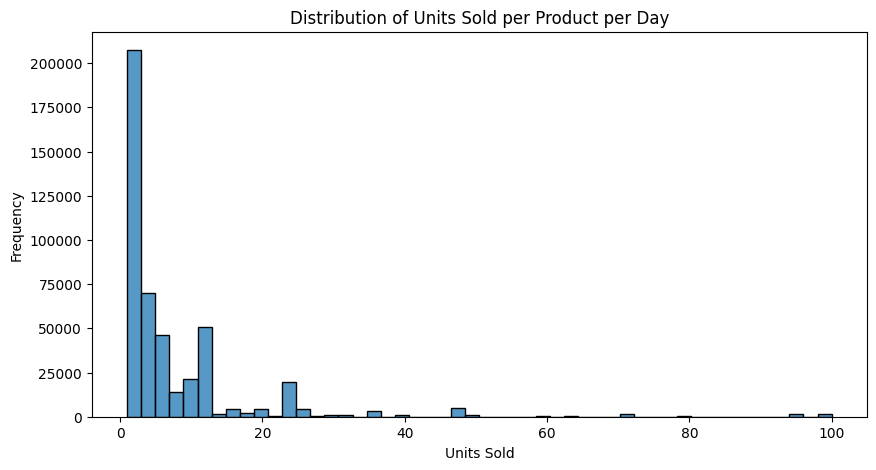

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_cleaned['UnitsSold'], bins=50)
plt.title("Distribution of Units Sold per Product per Day")
plt.xlabel("Units Sold")
plt.ylabel("Frequency")
plt.show()

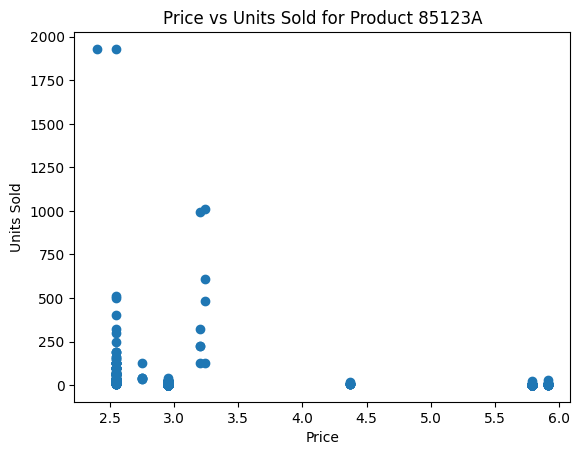

In [82]:
product_df = aggregated_df[aggregated_df['StockCode'] == '85123A']

plt.scatter(product_df['AvgPrice'], product_df['UnitsSold'])
plt.xlabel('Price')
plt.ylabel('Units Sold')
plt.title('Price vs Units Sold for Product 85123A')
plt.show()


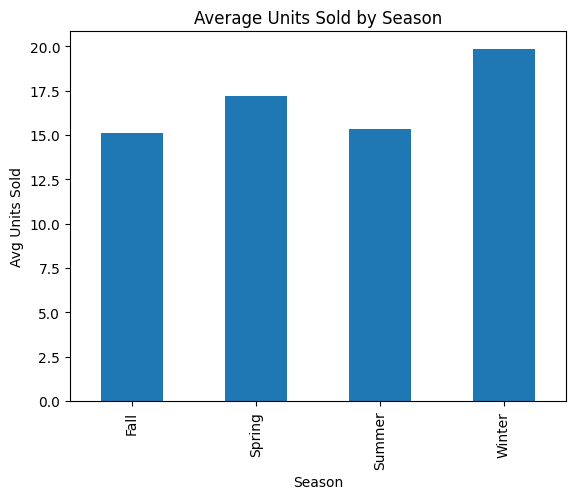

In [83]:
product_df = aggregated_df[aggregated_df['StockCode'] == '85123A']

seasonal_sales = product_df.groupby('Season')['UnitsSold'].mean()

seasonal_sales.plot(kind='bar', title='Average Units Sold by Season')
plt.ylabel('Avg Units Sold')
plt.show()


# Modeling Dataset for One Product

In [119]:
product_stats = (
    cleaned_df
    .groupby('StockCode')
    .agg(
        days_sold=('Quantity', 'count'),
        price_std=('UnitPrice', 'std')
    )
)

product_stats.sort_values(['days_sold', 'price_std'], ascending=False).head()


,days_sold,price_std
StockCode,,
85123A,2169,0.823935
85099B,1957,0.915187
22423,1710,4.536139
47566,1614,2.179374
20725,1421,1.130917


In [123]:
product_id = '85123A'  # example

product_df = cleaned_df[
    cleaned_df['StockCode'] == product_id
].copy()


In [124]:
product_df = pd.get_dummies(
    product_df,
    columns=['Season'],
    drop_first=True
)

In [125]:
product_df

,StockCode,Quantity,InvoiceDate,UnitPrice,DayOfWeek,Season_Spring,Season_Summer,Season_Winter
0,85123A,6,2010-12-01 08:26:00,2.55,Wednesday,False,False,True
49,85123A,6,2010-12-01 09:02:00,2.55,Wednesday,False,False,True
66,85123A,6,2010-12-01 09:32:00,2.55,Wednesday,False,False,True
220,85123A,64,2010-12-01 10:19:00,2.55,Wednesday,False,False,True
262,85123A,32,2010-12-01 10:39:00,2.55,Wednesday,False,False,True
...,...,...,...,...,...,...,...,...
539342,85123A,1,2011-12-08 16:30:00,5.79,Thursday,False,False,True
539979,85123A,32,2011-12-08 18:03:00,2.55,Thursday,False,False,True
540217,85123A,6,2011-12-08 19:55:00,2.95,Thursday,False,False,True
540837,85123A,3,2011-12-09 10:03:00,5.79,Friday,False,False,True


In [143]:
X = np.array(product_df[['UnitPrice', 'Season_Spring', 'Season_Summer', 'Season_Winter']])
y = np.array(product_df['Quantity'])



In [144]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [141]:
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + X.columns.tolist(),
    'Coefficient': [model.intercept_] + model.coef_.tolist()
})
print(coefficients)


         Feature  Coefficient
0      Intercept    41.093647
1      UnitPrice    -8.373695
2  Season_Spring     1.330730
3  Season_Summer    -0.201761
4  Season_Winter     4.236287


In [145]:
X_new = np.array([[5, 1, 0, 0]])  # [Price, Spring, Summer, Winterj]
predicted_units = model.predict(X_new)
print(predicted_units)


[0.55590374]


# Optimal Price, Predicted Units, and Expected Revenue

In [146]:
def revenue(price, season_vector, model):
    """
    price: scalar, price to test
    season_vector: array of shape (3,), dummy variables for [Spring, Summer, Winter]
    model: fitted linear regression
    """
    X_input = np.array([[price] + list(season_vector)])
    units_sold = model.predict(X_input)[0]
    return price * units_sold

In [147]:
def find_optimal_price(season_vector, model, price_min=0.1, price_max=20, step=0.1):
    prices = np.arange(price_min, price_max + step, step)
    revenues = [revenue(p, season_vector, model) for p in prices]
    max_idx = np.argmax(revenues)
    return prices[max_idx], revenues[max_idx]


In [148]:
seasons = {
    'Fall': [0, 0, 0],
    'Spring': [1, 0, 0],
    'Summer': [0, 1, 0],
    'Winter': [0, 0, 1]
}

results = {}

for season_name, season_vector in seasons.items():
    optimal_price, max_revenue = find_optimal_price(season_vector, model)
    predicted_units = model.predict(np.array([[optimal_price] + season_vector]))[0]
    
    results[season_name] = {
        'OptimalPrice': optimal_price,
        'PredictedUnitsSold': predicted_units,
        'ExpectedRevenue': max_revenue
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


        OptimalPrice  PredictedUnitsSold  ExpectedRevenue
Fall             2.5           20.159411        50.398526
Spring           2.5           21.490140        53.725350
Summer           2.4           20.795019        49.908046
Winter           2.7           22.720959        61.346589


The optimal price for Fall is: $2.50, making the total expected revenue: $50.40
The optimal price for Spring is: $2.50, making the total expected revenue: $53.73
The optimal price for Summer is: $2.40, making the total expected revenue: $49.91
The optimal price for Winter is: $2.70, making the total expected revenue: $61.35


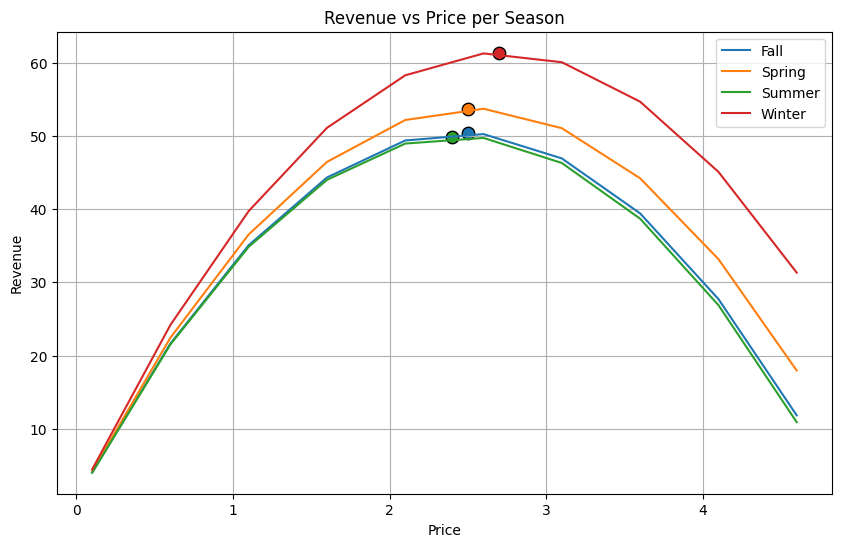

In [161]:
# Define a range of prices for plotting
price_range = np.arange(0.1, 5, 0.5)

plt.figure(figsize=(10,6))

for season_name, season_vector in seasons.items():
    # Compute revenue for all prices in range
    revenues = [revenue(p, season_vector, model) for p in price_range]
    
    # Plot the revenue curve
    plt.plot(price_range, revenues, label=season_name)
    
    # Mark the optimal price
    optimal_price = results[season_name]['OptimalPrice']
    max_revenue = results[season_name]['ExpectedRevenue']
    print(f'The optimal price for {season_name} is: ${optimal_price:.2f}, making the total expected revenue: ${max_revenue:.2f}')
    plt.scatter(optimal_price, max_revenue, marker='o', s=80, edgecolor='k')

plt.title("Revenue vs Price per Season")
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()

